In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-08 20:12:41.080147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 20:12:41.849203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 96
dataset_take = 1000
learning_rate = 1e-3
batch_per_file_size = 8
node_embedding_size = 15
layers = [96, 48, 32, 32, 24]

dataset = LayoutDataset(
    batch_size, dataset_take, 
    train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-08 20:12:44.391835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 20:12:44.472347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 20:12:44.472585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

train layout:nlp:default 1000
train layout:nlp:random 1000
train layout:xla:random 3000
train layout:xla:default 3000
test all_filenames 10000
valid all_filenames 1000


In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=2e-8,
    n_siblings=dataset.n_siblings
)

In [4]:
mlp.train(dataset, None)

2023-11-08 20:15:21.933698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-08 20:15:21.967925: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f50f9fb6ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 20:15:21.967944: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-08 20:15:22.006124: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 20:15:22.232575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-08 20:15:22.420164: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.115809 lr 0.00005
iteration 1000 training loss 2.866925 lr 0.00010
iteration 1500 training loss 2.3048506 lr 0.00015
iteration 2000 training loss 2.3349895 lr 0.00020
iteration 2500 training loss 2.3035953 lr 0.00025
iteration 3000 training loss 2.3525836 lr 0.00030
iteration 3500 training loss 1.9883093 lr 0.00035
iteration 4000 training loss 2.1477425 lr 0.00040
iteration 4500 training loss 2.4903421 lr 0.00045
iteration 5000 training loss 1.9787458 lr 0.00050
iteration 5500 training loss 1.703256 lr 0.00055
iteration 6000 training loss 1.8801144 lr 0.00060
iteration 6500 training loss 1.6805575 lr 0.00065
iteration 7000 training loss 1.7657626 lr 0.00070
iteration 7500 training loss 1.8565553 lr 0.00075
iteration 8000 training loss 1.6939093 lr 0.00080
iteration 8500 training loss 1.8759106 lr 0.00085
iteration 9000 training loss 1.330386 lr 0.00090
iteration 9500 training loss 1.5227753 lr 0.00095
iteration 10000 training loss 1.1529435 lr 0.00100
layo

iteration 70000 training loss 1.132369 lr 0.00087
layout:nlp:random 0.8966134288524421
layout:nlp:default 0.49307060761244437
layout:xla:random 0.6499316598128718
layout:xla:default 0.2930569563767567
epoch 0, it 70000 validation loss -0.583
iteration 70500 training loss 0.91039985 lr 0.00087
iteration 71000 training loss 1.6096181 lr 0.00087
iteration 71500 training loss 1.2455117 lr 0.00087
iteration 72000 training loss 1.6478931 lr 0.00086
iteration 72500 training loss 0.5900489 lr 0.00086
iteration 73000 training loss 1.7056352 lr 0.00086
iteration 73500 training loss 1.2151693 lr 0.00086
iteration 74000 training loss 1.5313622 lr 0.00085
iteration 74500 training loss 1.2077776 lr 0.00085
iteration 75000 training loss 0.8621326 lr 0.00085
iteration 75500 training loss 1.0468875 lr 0.00085
iteration 76000 training loss 1.175147 lr 0.00085
iteration 76500 training loss 0.708637 lr 0.00084
iteration 77000 training loss 1.346167 lr 0.00084
iteration 77500 training loss 1.552917 lr 0.00

iteration 136500 training loss 1.3801957 lr 0.00052
iteration 137000 training loss 1.2709657 lr 0.00051
iteration 137500 training loss 1.2472037 lr 0.00051
iteration 138000 training loss 0.8558889 lr 0.00051
iteration 138500 training loss 1.3618093 lr 0.00050
iteration 139000 training loss 1.2629766 lr 0.00050
iteration 139500 training loss 1.3467767 lr 0.00050
iteration 140000 training loss 1.3295836 lr 0.00050
layout:nlp:random 0.922458730518197
layout:nlp:default 0.48607971389776805
layout:xla:random 0.6601169098429008
layout:xla:default 0.3338156762539439
epoch 0, it 140000 validation loss -0.601
iteration 140500 training loss 1.2013091 lr 0.00049
iteration 141000 training loss 1.2221352 lr 0.00049
iteration 141500 training loss 0.7557684 lr 0.00049
iteration 142000 training loss 0.7342655 lr 0.00048
iteration 142500 training loss 0.9976152 lr 0.00048
iteration 143000 training loss 0.96932864 lr 0.00048
iteration 143500 training loss 0.6270029 lr 0.00047
iteration 144000 training l

## Evaluate validation set

In [5]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

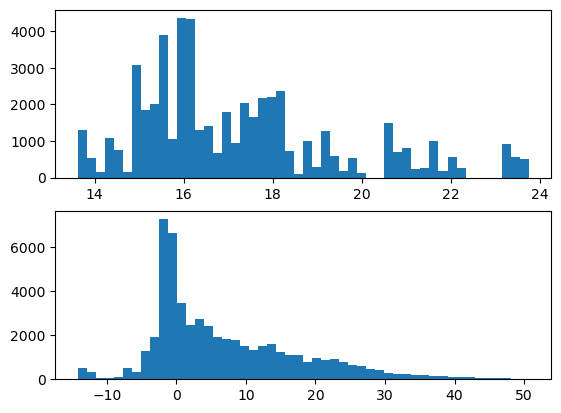

In [6]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [7]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:xla:default:inception_v3_batch_128_train',b'layout:xla:default:inception_v3_batch_128_tr...,3,-14.167041,21.680357
b'layout:xla:random:inception_v3_batch_128_train',b'layout:xla:random:inception_v3_batch_128_train',3,-13.492805,21.680561
b'layout:xla:random:resnet50.4x4.fp16',b'layout:xla:random:resnet50.4x4.fp16',9,-8.850499,19.288380
b'layout:xla:random:resnet_v1_50_official_batch_128_bf16',b'layout:xla:random:resnet_v1_50_official_batc...,8,-8.803408,20.910069
b'layout:xla:default:resnet50.4x4.fp16',b'layout:xla:default:resnet50.4x4.fp16',22,-7.636310,19.288330
b'layout:xla:default:mlperf_bert_batch_24_2x2',b'layout:xla:default:mlperf_bert_batch_24_2x2',5,-5.736164,23.313334
b'layout:nlp:default:talking-heads_large_batch_size_16_train',b'layout:nlp:default:talking-heads_large_batch...,1,-5.454749,18.689413
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16',b'layout:xla:default:resnet_v1_50_official_bat...,6,-5.169949,20.910105
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,206,-4.020878,15.862122


Text(0.5, 1.0, "b'layout:nlp:random:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train'")

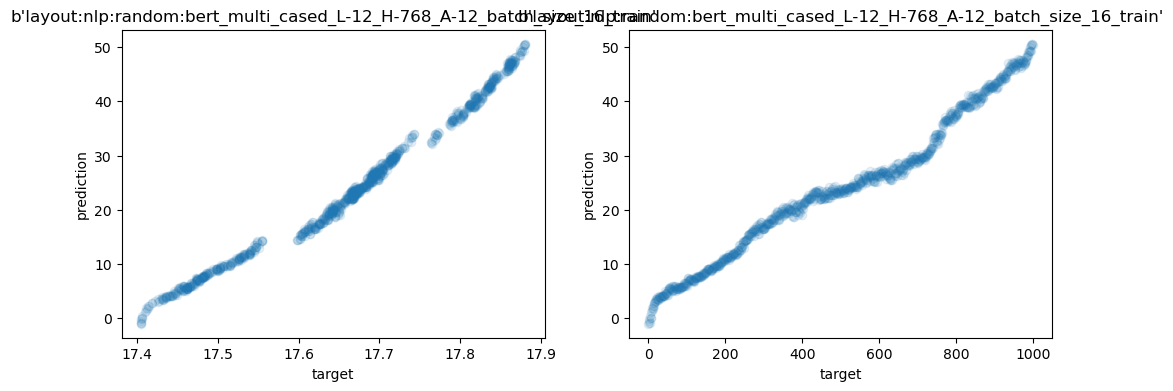

In [20]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

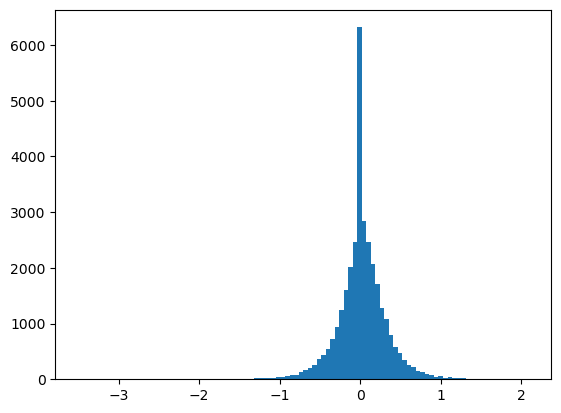

In [9]:
plt.hist(mlp.dense_layer_node_1.kernel.numpy().flatten(), bins=100);

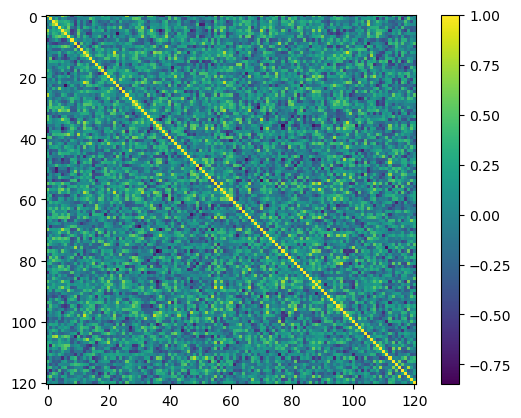

In [10]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [ ]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

In [ ]:
val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

In [ ]:
val_df

In [ ]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

In [ ]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

In [ ]:
np.mean([0.3195286, 0.510239, 0.9235297, 0.659144])

In [ ]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

In [ ]:
valid_nodes_list = []
for batch in dataset.valid_data:
    df = pd.DataFrame(
        np.stack([
            batch['layout_id'].numpy(), 
            batch['valid_nodes'].numpy()], axis=-1),
        columns=['ID', 'valid_nodes']
    ).drop_duplicates('ID')
    valid_nodes_list.append(df)
valid_nodes = pd.concat(valid_nodes_list).drop_duplicates('ID')
valid_nodes

In [ ]:
valid_nodes.set_index('ID', inplace=True)
valid_nodes['scores'] = val_scores
valid_nodes

In [ ]:
valid_nodes.reset_index(inplace=True)
valid_nodes

In [ ]:
valid_nodes['subset'] = valid_nodes['ID'].apply(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
valid_nodes

In [ ]:
plt.scatter(
    valid_nodes['scores'],
    valid_nodes['valid_nodes']
)

In [ ]:
subset = 'layout:nlp:default'
valid_nodes_subset = valid_nodes[valid_nodes['subset'] == subset]
print(valid_nodes_subset.sort_values('valid_nodes').iloc[-1])
plt.scatter(
    valid_nodes_subset['scores'],
    valid_nodes_subset['valid_nodes']
)

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [ ]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

In [ ]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

In [ ]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_11_07_01_33.csv')